# Method 6 - Rest Ideas After 10

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 10].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

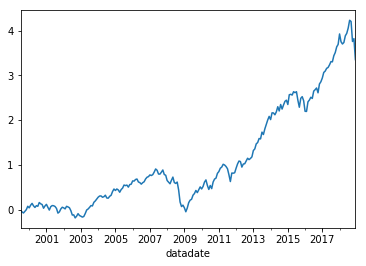

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.077867
2000-12-31    0.007075
2001-12-31   -0.027194
2002-12-31   -0.175016
2003-12-31    0.420809
2004-12-31    0.181764
2005-12-31    0.073781
2006-12-31    0.107474
2007-12-31    0.017589
2008-12-31   -0.376849
2009-12-31    0.369621
2010-12-31    0.199809
2011-12-31    0.006963
2012-12-31    0.194473
2013-12-31    0.414394
2014-12-31    0.117241
2015-12-31   -0.003323
2016-12-31    0.123135
2017-12-31    0.216030
2018-12-31   -0.072336
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2257.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.21e-182
Time:                        14:02:32   Log-Likelihood:                 835.18
No. Observations:                 234   AIC:                            -1660.
Df Residuals:                     229   BIC:                            -1643.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.643      0.000       0.001       0.003
mktrf          0.9549      0.013     74.280      0.000       0.930       0.980
me             0.2211      0.015     14.788      0.000       0.192       0.251
ia             0.1025      0.023      4.510      0.000       0.058       0.147
roe            0.0525      0.019      2.698      0.008       0.014       0.091
==============================================================================
Omnibus:                       11.185   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               25.203
Skew:                          -0.001   Prob(JB):                     3.37e-06
Kurtosis:                       4.608   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1260.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.25e-154
Time:                        14:02:32   Log-Likelihood:                 835.18
No. Observations:                 234   AIC:                            -1660.
Df Residuals:                     229   BIC:                            -1643.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      4.335      0.000       0.001       0.003
mktrf          0.9549      0.017     54.802      0.000       0.921       0.989
me             0.2211      0.034      6.567      0.000       0.155       0.287
ia             0.1025      0.046      2.209      0.027       0.012       0.193
roe            0.0525      0.021      2.464      0.014       0.011       0.094
==============================================================================
Omnibus:                       11.185   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               25.203
Skew:                          -0.001   Prob(JB):                     3.37e-06
Kurtosis:                       4.608   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1653.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.32e-167
Time:                        14:02:32   Log-Likelihood:                 835.18
No. Observations:                 234   AIC:                            -1660.
Df Residuals:                     229   BIC:                            -1643.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.679      0.000       0.001       0.003
mktrf          0.9549      0.016     60.051      0.000       0.924       0.986
me             0.2211      0.032      6.896      0.000       0.158       0.284
ia             0.1025      0.053      1.919      0.055      -0.002       0.207
roe            0.0525      0.022      2.340      0.019       0.009       0.096
==============================================================================
Omnibus:                       11.185   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               25.203
Skew:                          -0.001   Prob(JB):                     3.37e-06
Kurtosis:                       4.608   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1709.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.78e-178
Time:                        14:02:32   Log-Likelihood:                 829.36
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.000      3.700      0.000       0.001       0.003
mktrf          0.9663      0.013     73.018      0.000       0.940       0.992
smb            0.2560      0.017     14.658      0.000       0.222       0.290
hml            0.0077      0.021      0.373      0.710      -0.033       0.048
rmw            0.0938      0.023      4.027      0.000       0.048       0.140
cma            0.0766      0.030      2.588      0.010       0.018       0.135
==============================================================================
Omnibus:                       21.166   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.855
Skew:                           0.018   Prob(JB):                     6.18e-19
Kurtosis:                       5.932   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     915.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.09e-148
Time:                        14:02:32   Log-Likelihood:                 829.36
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.469      0.001       0.001       0.003
mktrf          0.9663      0.021     46.801      0.000       0.926       1.007
smb            0.2560      0.026      9.741      0.000       0.204       0.307
hml            0.0077      0.048      0.160      0.873      -0.086       0.102
rmw            0.0938      0.025      3.761      0.000       0.045       0.143
cma            0.0766      0.047      1.614      0.107      -0.016       0.170
==============================================================================
Omnibus:                       21.166   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.855
Skew:                           0.018   Prob(JB):                     6.18e-19
Kurtosis:                       5.932   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1279.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.42e-164
Time:                        14:02:32   Log-Likelihood:                 829.36
No. Observations:                 234   AIC:                            -1647.
Df Residuals:                     228   BIC:                            -1626.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.557      0.000       0.001       0.003
mktrf          0.9663      0.020     48.455      0.000       0.927       1.005
smb            0.2560      0.026      9.841      0.000       0.205       0.307
hml            0.0077      0.054      0.143      0.886      -0.097       0.113
rmw            0.0938      0.027      3.521      0.000       0.042       0.146
cma            0.0766      0.045      1.693      0.091      -0.012       0.165
==============================================================================
Omnibus:                       21.166   Durbin-Watson:                   1.608
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.855
Skew:                           0.018   Prob(JB):                     6.18e-19
Kurtosis:                       5.932   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1792.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.79e-171
Time:                        14:02:32   Log-Likelihood:                 808.90
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.798      0.000       0.001       0.003
mktrf          0.9415      0.013     71.094      0.000       0.915       0.968
smb            0.2035      0.017     12.311      0.000       0.171       0.236
hml            0.1167      0.016      7.104      0.000       0.084       0.149
umd            0.0141      0.011      1.308      0.192      -0.007       0.035
==============================================================================
Omnibus:                       24.307   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.461
Skew:                           0.122   Prob(JB):                     4.63e-24
Kurtosis:                       6.311   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1149.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.05e-150
Time:                        14:02:33   Log-Likelihood:                 808.90
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.043      0.000       0.001       0.004
mktrf          0.9415      0.020     48.223      0.000       0.903       0.980
smb            0.2035      0.033      6.250      0.000       0.140       0.267
hml            0.1167      0.054      2.169      0.030       0.011       0.222
umd            0.0141      0.018      0.783      0.434      -0.021       0.049
==============================================================================
Omnibus:                       24.307   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.461
Skew:                           0.122   Prob(JB):                     4.63e-24
Kurtosis:                       6.311   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1461.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.11e-161
Time:                        14:02:33   Log-Likelihood:                 808.90
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      4.186      0.000       0.001       0.004
mktrf          0.9415      0.018     52.595      0.000       0.906       0.977
smb            0.2035      0.034      5.934      0.000       0.136       0.271
hml            0.1167      0.063      1.851      0.064      -0.007       0.240
umd            0.0141      0.014      1.002      0.316      -0.013       0.042
==============================================================================
Omnibus:                       24.307   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.461
Skew:                           0.122   Prob(JB):                     4.63e-24
Kurtosis:                       6.311   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     998.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-88
Time:                        14:02:33   Log-Likelihood:                 410.39
No. Observations:                 120   AIC:                            -810.8
Df Residuals:                     115   BIC:                            -796.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.051      0.003       0.001       0.004
mktrf          0.9634      0.021     46.222      0.000       0.922       1.005
me             0.2100      0.021     10.202      0.000       0.169       0.251
ia             0.1557      0.032      4.831      0.000       0.092       0.220
roe            0.0557      0.029      1.952      0.053      -0.001       0.112
==============================================================================
Omnibus:                        4.673   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                6.376
Skew:                           0.003   Prob(JB):                       0.0413
Kurtosis:                       4.129   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     654.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.36e-78
Time:                        14:02:33   Log-Likelihood:                 410.39
No. Observations:                 120   AIC:                            -810.8
Df Residuals:                     115   BIC:                            -796.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.727      0.006       0.001       0.004
mktrf          0.9634      0.027     36.039      0.000       0.911       1.016
me             0.2100      0.036      5.884      0.000       0.140       0.280
ia             0.1557      0.046      3.389      0.001       0.066       0.246
roe            0.0557      0.023      2.457      0.014       0.011       0.100
==============================================================================
Omnibus:                        4.673   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                6.376
Skew:                           0.003   Prob(JB):                       0.0413
Kurtosis:                       4.129   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1174.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.35e-92
Time:                        14:02:33   Log-Likelihood:                 410.39
No. Observations:                 120   AIC:                            -810.8
Df Residuals:                     115   BIC:                            -796.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.897      0.004       0.001       0.004
mktrf          0.9634      0.022     44.626      0.000       0.921       1.006
me             0.2100      0.035      5.984      0.000       0.141       0.279
ia             0.1557      0.048      3.261      0.001       0.062       0.249
roe            0.0557      0.021      2.710      0.007       0.015       0.096
==============================================================================
Omnibus:                        4.673   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                6.376
Skew:                           0.003   Prob(JB):                       0.0413
Kurtosis:                       4.129   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     721.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.66e-84
Time:                        14:02:33   Log-Likelihood:                 404.95
No. Observations:                 120   AIC:                            -797.9
Df Residuals:                     114   BIC:                            -781.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.765      0.007       0.001       0.004
mktrf          0.9993      0.023     43.264      0.000       0.954       1.045
smb            0.2633      0.026     10.066      0.000       0.212       0.315
hml            0.0012      0.032      0.039      0.969      -0.062       0.065
rmw            0.1229      0.038      3.250      0.002       0.048       0.198
cma            0.1337      0.041      3.230      0.002       0.052       0.216
==============================================================================
Omnibus:                       12.092   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.496
Skew:                           0.028   Prob(JB):                     1.96e-08
Kurtosis:                       5.664   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     582.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.10e-79
Time:                        14:02:33   Log-Likelihood:                 404.95
No. Observations:                 120   AIC:                            -797.9
Df Residuals:                     114   BIC:                            -781.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.601      0.009       0.001       0.004
mktrf          0.9993      0.038     26.417      0.000       0.925       1.073
smb            0.2633      0.037      7.047      0.000       0.190       0.337
hml            0.0012      0.081      0.015      0.988      -0.158       0.160
rmw            0.1229      0.055      2.247      0.025       0.016       0.230
cma            0.1337      0.063      2.114      0.034       0.010       0.258
==============================================================================
Omnibus:                       12.092   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.496
Skew:                           0.028   Prob(JB):                     1.96e-08
Kurtosis:                       5.664   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1087.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.15e-94
Time:                        14:02:33   Log-Likelihood:                 404.95
No. Observations:                 120   AIC:                            -797.9
Df Residuals:                     114   BIC:                            -781.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.941      0.003       0.001       0.004
mktrf          0.9993      0.036     27.824      0.000       0.929       1.070
smb            0.2633      0.037      7.136      0.000       0.191       0.336
hml            0.0012      0.091      0.014      0.989      -0.178       0.181
rmw            0.1229      0.059      2.090      0.037       0.008       0.238
cma            0.1337      0.064      2.101      0.036       0.009       0.259
==============================================================================
Omnibus:                       12.092   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.496
Skew:                           0.028   Prob(JB):                     1.96e-08
Kurtosis:                       5.664   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     728.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-80
Time:                        14:02:33   Log-Likelihood:                 392.06
No. Observations:                 120   AIC:                            -774.1
Df Residuals:                     115   BIC:                            -760.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.813      0.000       0.002       0.005
mktrf          0.9440      0.021     44.128      0.000       0.902       0.986
smb            0.2042      0.024      8.383      0.000       0.156       0.252
hml            0.1566      0.024      6.418      0.000       0.108       0.205
umd            0.0117      0.015      0.781      0.437      -0.018       0.042
==============================================================================
Omnibus:                       14.895   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.897
Skew:                           0.054   Prob(JB):                     1.20e-12
Kurtosis:                       6.312   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     808.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.55e-83
Time:                        14:02:33   Log-Likelihood:                 392.06
No. Observations:                 120   AIC:                            -774.1
Df Residuals:                     115   BIC:                            -760.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.646      0.000       0.002       0.005
mktrf          0.9440      0.031     30.032      0.000       0.882       1.006
smb            0.2042      0.038      5.429      0.000       0.130       0.278
hml            0.1566      0.066      2.359      0.018       0.026       0.287
umd            0.0117      0.021      0.566      0.571      -0.029       0.052
==============================================================================
Omnibus:                       14.895   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.897
Skew:                           0.054   Prob(JB):                     1.20e-12
Kurtosis:                       6.312   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1400.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-96
Time:                        14:02:33   Log-Likelihood:                 392.06
No. Observations:                 120   AIC:                            -774.1
Df Residuals:                     115   BIC:                            -760.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.070      0.000       0.002       0.005
mktrf          0.9440      0.026     36.701      0.000       0.894       0.994
smb            0.2042      0.041      5.013      0.000       0.124       0.284
hml            0.1566      0.074      2.113      0.035       0.011       0.302
umd            0.0117      0.017      0.697      0.486      -0.021       0.045
==============================================================================
Omnibus:                       14.895   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               54.897
Skew:                           0.054   Prob(JB):                     1.20e-12
Kurtosis:                       6.312   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2002.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.27e-101
Time:                        14:02:33   Log-Likelihood:                 456.09
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.739      0.000       0.001       0.003
mktrf          0.9487      0.013     71.252      0.000       0.922       0.975
me             0.2475      0.021     12.041      0.000       0.207       0.288
ia            -0.0637      0.029     -2.234      0.028      -0.120      -0.007
roe           -0.0122      0.025     -0.488      0.627      -0.062       0.037
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.132
Skew:                          -0.077   Prob(JB):                        0.936
Kurtosis:                       2.936   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2286.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.12e-104
Time:                        14:02:33   Log-Likelihood:                 456.09
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      4.239      0.000       0.001       0.003
mktrf          0.9487      0.012     79.927      0.000       0.925       0.972
me             0.2475      0.024     10.268      0.000       0.200       0.295
ia            -0.0637      0.030     -2.093      0.036      -0.123      -0.004
roe           -0.0122      0.026     -0.469      0.639      -0.063       0.039
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.132
Skew:                          -0.077   Prob(JB):                        0.936
Kurtosis:                       2.936   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2511.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.62e-106
Time:                        14:02:33   Log-Likelihood:                 456.09
No. Observations:                 114   AIC:                            -902.2
Df Residuals:                     109   BIC:                            -888.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      3.756      0.000       0.001       0.003
mktrf          0.9487      0.011     83.851      0.000       0.927       0.971
me             0.2475      0.027      9.293      0.000       0.195       0.300
ia            -0.0637      0.034     -1.857      0.063      -0.131       0.004
roe           -0.0122      0.022     -0.546      0.585      -0.056       0.032
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.132
Skew:                          -0.077   Prob(JB):                        0.936
Kurtosis:                       2.936   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2468.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.43e-109
Time:                        14:02:33   Log-Likelihood:                 481.00
No. Observations:                 114   AIC:                            -950.0
Df Residuals:                     108   BIC:                            -933.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.605      0.000       0.001       0.002
mktrf          0.9519      0.010     92.842      0.000       0.932       0.972
smb            0.2319      0.017     13.932      0.000       0.199       0.265
hml           -0.0422      0.021     -1.989      0.049      -0.084      -0.000
rmw           -0.0678      0.026     -2.609      0.010      -0.119      -0.016
cma           -0.0431      0.033     -1.307      0.194      -0.109       0.022
==============================================================================
Omnibus:                        2.528   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.953
Skew:                          -0.272   Prob(JB):                        0.377
Kurtosis:                       3.341   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3979.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.08e-120
Time:                        14:02:33   Log-Likelihood:                 481.00
No. Observations:                 114   AIC:                            -950.0
Df Residuals:                     108   BIC:                            -933.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      3.205      0.001       0.001       0.002
mktrf          0.9519      0.009    103.111      0.000       0.934       0.970
smb            0.2319      0.019     12.133      0.000       0.194       0.269
hml           -0.0422      0.020     -2.077      0.038      -0.082      -0.002
rmw           -0.0678      0.020     -3.453      0.001      -0.106      -0.029
cma           -0.0431      0.040     -1.084      0.278      -0.121       0.035
==============================================================================
Omnibus:                        2.528   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.953
Skew:                          -0.272   Prob(JB):                        0.377
Kurtosis:                       3.341   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     8105.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.59e-137
Time:                        14:02:33   Log-Likelihood:                 481.00
No. Observations:                 114   AIC:                            -950.0
Df Residuals:                     108   BIC:                            -933.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.000      2.750      0.006       0.000       0.002
mktrf          0.9519      0.008    118.047      0.000       0.936       0.968
smb            0.2319      0.018     12.824      0.000       0.196       0.267
hml           -0.0422      0.018     -2.289      0.022      -0.078      -0.006
rmw           -0.0678      0.021     -3.179      0.001      -0.110      -0.026
cma           -0.0431      0.041     -1.061      0.289      -0.123       0.037
==============================================================================
Omnibus:                        2.528   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                1.953
Skew:                          -0.272   Prob(JB):                        0.377
Kurtosis:                       3.341   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2777.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.14e-108
Time:                        14:02:33   Log-Likelihood:                 474.55
No. Observations:                 114   AIC:                            -939.1
Df Residuals:                     109   BIC:                            -925.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.875      0.005       0.000       0.002
mktrf          0.9594      0.011     89.404      0.000       0.938       0.981
smb            0.2465      0.017     14.734      0.000       0.213       0.280
hml           -0.0295      0.017     -1.714      0.089      -0.064       0.005
umd           -0.0017      0.013     -0.130      0.897      -0.027       0.024
==============================================================================
Omnibus:                        3.942   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.385
Skew:                          -0.325   Prob(JB):                        0.184
Kurtosis:                       3.538   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2869.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.00e-109
Time:                        14:02:33   Log-Likelihood:                 474.55
No. Observations:                 114   AIC:                            -939.1
Df Residuals:                     109   BIC:                            -925.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.495      0.013       0.000       0.002
mktrf          0.9594      0.011     87.431      0.000       0.938       0.981
smb            0.2465      0.019     13.202      0.000       0.210       0.283
hml           -0.0295      0.013     -2.220      0.026      -0.056      -0.003
umd           -0.0017      0.008     -0.216      0.829      -0.017       0.014
==============================================================================
Omnibus:                        3.942   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.385
Skew:                          -0.325   Prob(JB):                        0.184
Kurtosis:                       3.538   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4406.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.66e-119
Time:                        14:02:33   Log-Likelihood:                 474.55
No. Observations:                 114   AIC:                            -939.1
Df Residuals:                     109   BIC:                            -925.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.245      0.025       0.000       0.002
mktrf          0.9594      0.010     94.505      0.000       0.940       0.979
smb            0.2465      0.017     14.667      0.000       0.214       0.279
hml           -0.0295      0.013     -2.340      0.019      -0.054      -0.005
umd           -0.0017      0.008     -0.200      0.841      -0.018       0.015
==============================================================================
Omnibus:                        3.942   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.385
Skew:                          -0.325   Prob(JB):                        0.184
Kurtosis:                       3.538   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""